In [42]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.style as style
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [2]:
style.use('classic')

Zajmiemy się analizą danych o transakcjach na kartach kredytowych, a naszym celem będzie zbudowanie modelu zdolnego rozpoznać fraudy. Dane zostały opublikowane na serwisie kaggle.com. W celu właściwej oceny jakości modelu wydzielimy zbiór walidacyjny("hold-out set"), by ostateczna ewaluacja odbyła się na danych których jeszcze "nie widzieliśmy". 

In [3]:
data = pd.read_csv('creditcard.csv')
data,hold_out = train_test_split(data,test_size=0.35,stratify=data['Class'],random_state=21)  #arbitralny wybór wielkości hold-outu i zadbanie o równy rozkład targetu

In [41]:
data.info()
data.isnull().any().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185124 entries, 26812 to 97443
Data columns (total 31 columns):
Time      185124 non-null float64
V1        185124 non-null float64
V2        185124 non-null float64
V3        185124 non-null float64
V4        185124 non-null float64
V5        185124 non-null float64
V6        185124 non-null float64
V7        185124 non-null float64
V8        185124 non-null float64
V9        185124 non-null float64
V10       185124 non-null float64
V11       185124 non-null float64
V12       185124 non-null float64
V13       185124 non-null float64
V14       185124 non-null float64
V15       185124 non-null float64
V16       185124 non-null float64
V17       185124 non-null float64
V18       185124 non-null float64
V19       185124 non-null float64
V20       185124 non-null float64
V21       185124 non-null float64
V22       185124 non-null float64
V23       185124 non-null float64
V24       185124 non-null float64
V25       185124 non-null float64
V2

0

Widzimy, że wszystkie kolumny poza "Class" są typu float. Dostrzegamy też już pierwszy problem związany z naszymi danymi - poza zmiennymi "Class", "Amount" i "Time" mamy do czynienia z danymi zakodowanymi nazwami "V...". Utrudni nam to "zrozumienie" danych i ograniczy pole manewru przy tzw. feature engineering. Z drugiej strony, jest i dobra wiadomość:nie mamy brakujących danych, o uzupełnienie których musielibyśmy się zatroszczyć. Po wydzieleniu zbioru walidacyjnego pozostało nam ok. 185 tys. rekordów.

In [11]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,...,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000
mean,94800.185956,-0.002927,0.000832,0.001746,-0.003746,-0.000209,-0.000501,0.000192,-0.001361,0.003405,...,-0.000739,0.000845,-0.000096,0.000235,-0.000803,-0.001468,-0.000372,0.000044,88.152377,0.001729
std,47479.982145,1.967512,1.669363,1.514763,1.414687,1.391761,1.340648,1.255182,1.216856,1.100174,...,0.743545,0.727349,0.633952,0.606339,0.521908,0.482484,0.406371,0.335984,255.288739,0.041540
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000,0.000000
25%,54182.750000,-0.920424,-0.595819,-0.888159,-0.851680,-0.690318,-0.769846,-0.552346,-0.208154,-0.640841,...,-0.228623,-0.542054,-0.161417,-0.354853,-0.318634,-0.327471,-0.070929,-0.053018,5.550000,0.000000
50%,84759.000000,0.013435,0.068600,0.179859,-0.022760,-0.055342,-0.273634,0.039859,0.022990,-0.049172,...,-0.029492,0.007346,-0.010786,0.041202,0.016190,-0.053548,0.001465,0.011310,21.980000,0.000000
75%,139323.000000,1.314699,0.805852,1.029189,0.742206,0.610969,0.396147,0.571946,0.326724,0.600271,...,0.186429,0.531068,0.148051,0.441199,0.350093,0.239295,0.091044,0.078150,77.000000,0.000000
max,172787.000000,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,27.202839,10.503090,22.528412,4.584549,6.070850,3.517346,31.612198,33.847808,25691.160000,1.000000


Zgodnie z opisem z kaggle.com, zmienne V1 do V28 dostajemy już ustandaryzowane, tj. mają one zerową średnią i jednostkową wariancję. Nieduże odchylenia od tego wzoru wynikają zapewne z wydzielenia zbioru walidacyjnego - normalizowane były dane oryginalne. Po rzuceniu okiem na minimum i maksimum z kolumny czasu(i szybkich rachunkach seund na godziny) potwierdzamy też, że istotnie nasze dany pochodzą z przestrzeni dwóch dni. Zdaje się również, że niektóre kolumny zawierają mocno odstające obserwacje -  w zmiennyhc o średniej 0 i wariancji 1 widzmy obserwaje o wartościach np. 20.

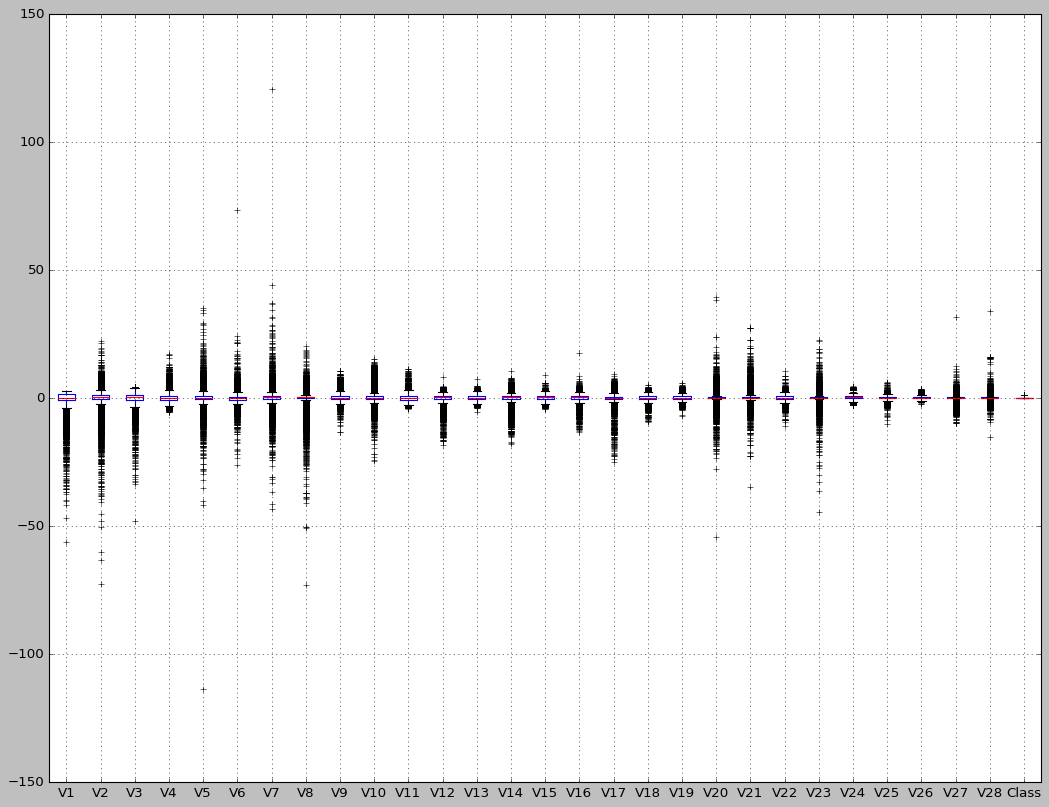

In [35]:
plt.figure(figsize=[16,12])
data.drop(['Time','Class'],axis=1).boxplot()
plt.show()

Wykresy pudełkowe wyraźnie potwiedzają obecność outliersów. Z jednej strony to zjawisko potrafi być problematyczne, szczególnie gdy nie bardzo jesteśmy w stanie wytłumaczyć obecność odstających obserwacji czy uzasadnić wyrzucenie ich ze zbioru. Z drugiej - skoro szukamy niejako "obserwacji odstających" w zmiennej celu(bardzo rzadka pozytywna klasa), to może nasz model będzie w stanie wyuczyć się powiązań pomiędzy nimi? 

Warto może jeszcze zwrócić uwagę na dość ciekawy, mocno skośny rozkład zmiennej V1.

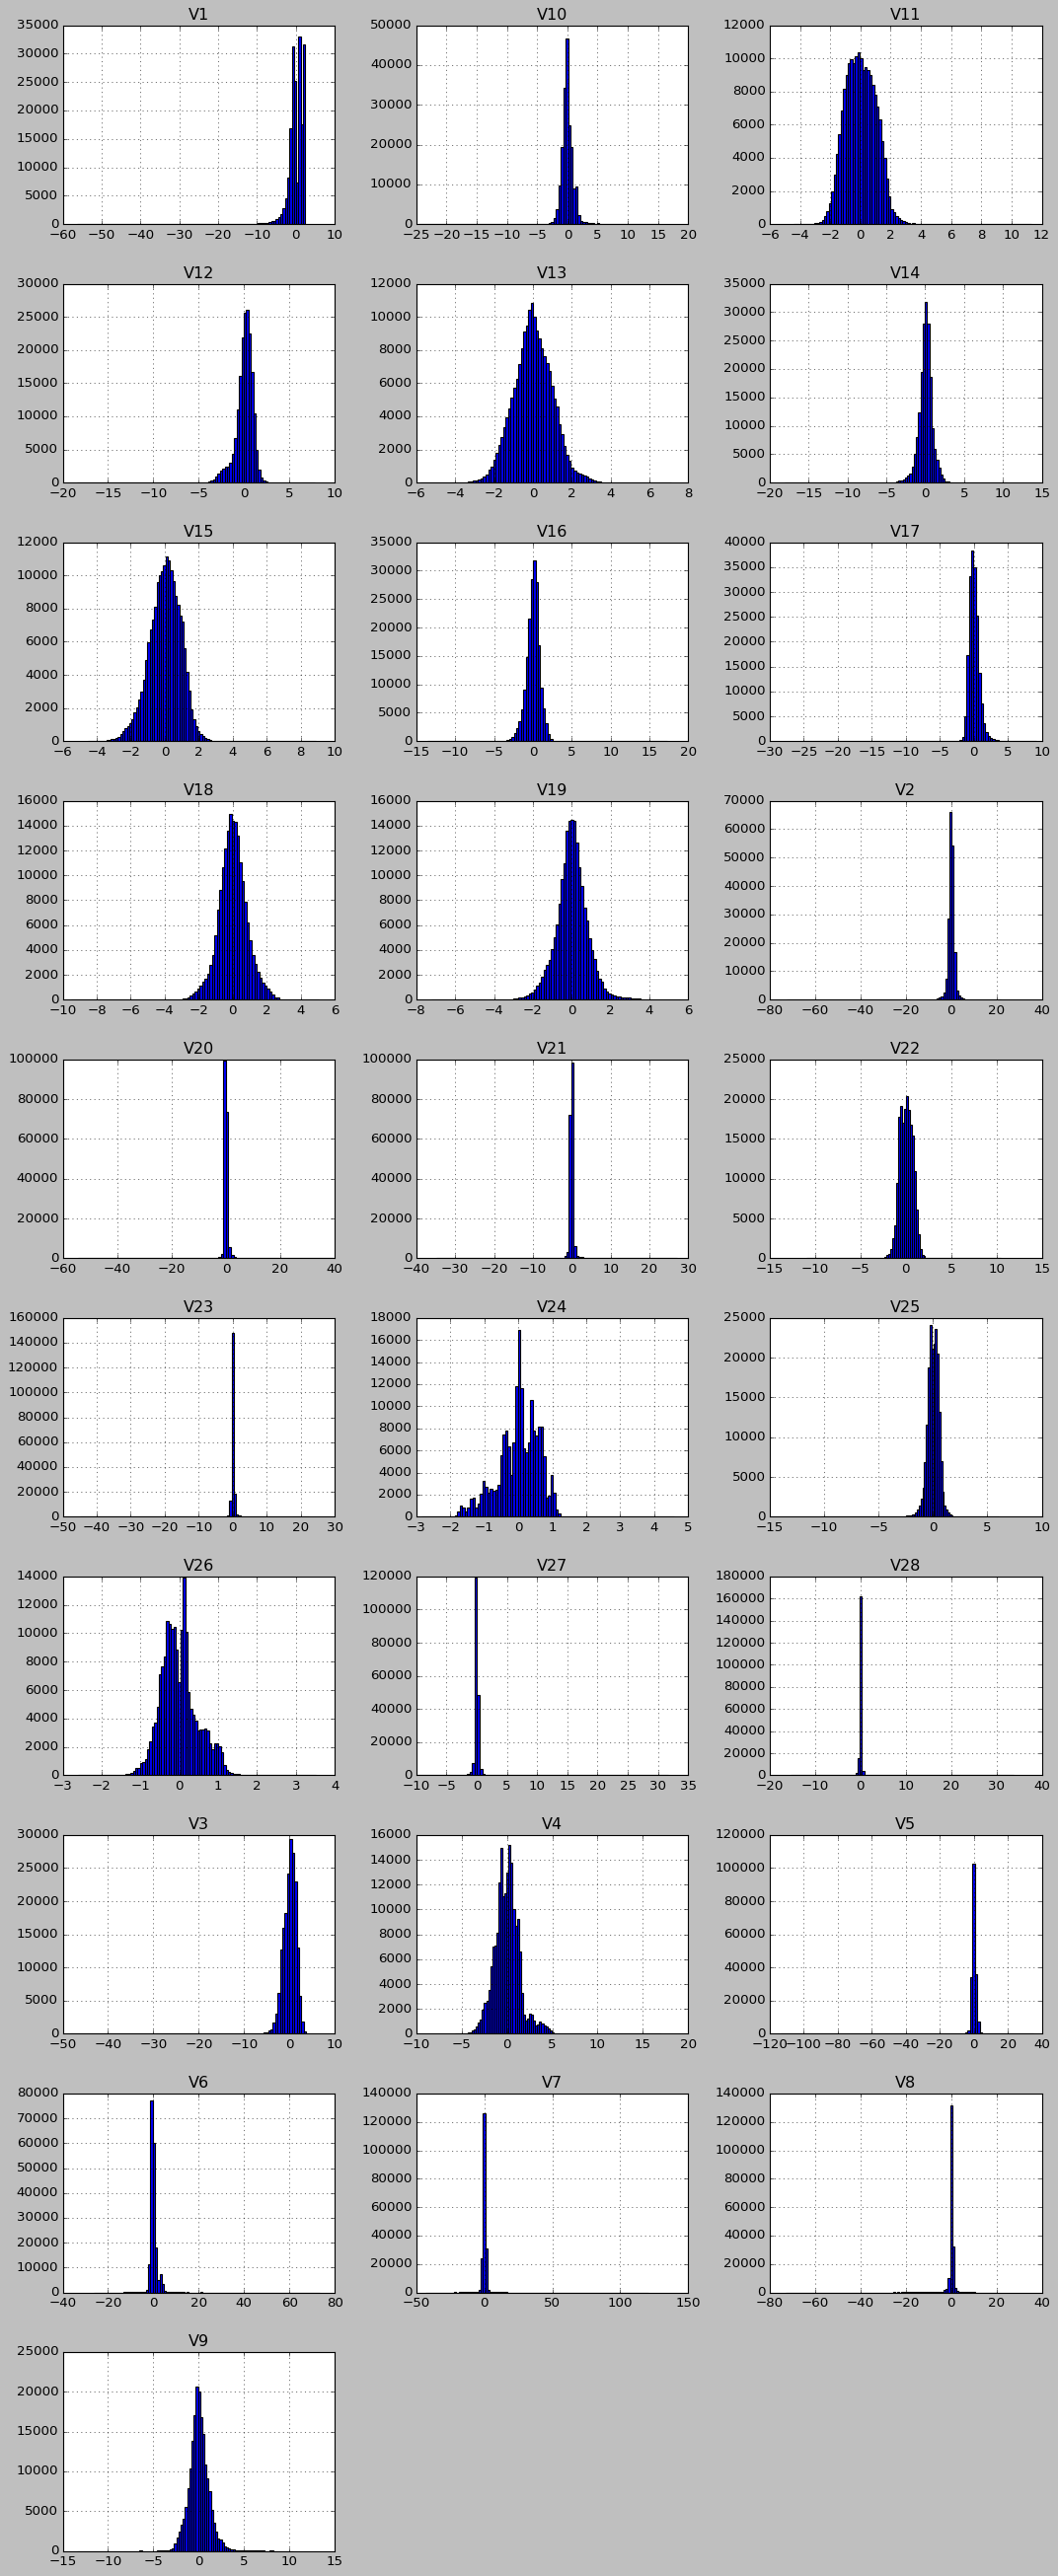

In [38]:
data.drop(['Time','Class','Amount'],axis=1).hist(bins=100, figsize=(16, 40),layout=(10,3));

Histogramy przywodziłyby na myśl raczej rozkłady normalne, gdyby nie już bardzo wyraźnie uwidaczniające się ciężkie ogony wielu zmiennych. Wyjątkiem jest tu wspomniana już zmienna V1.

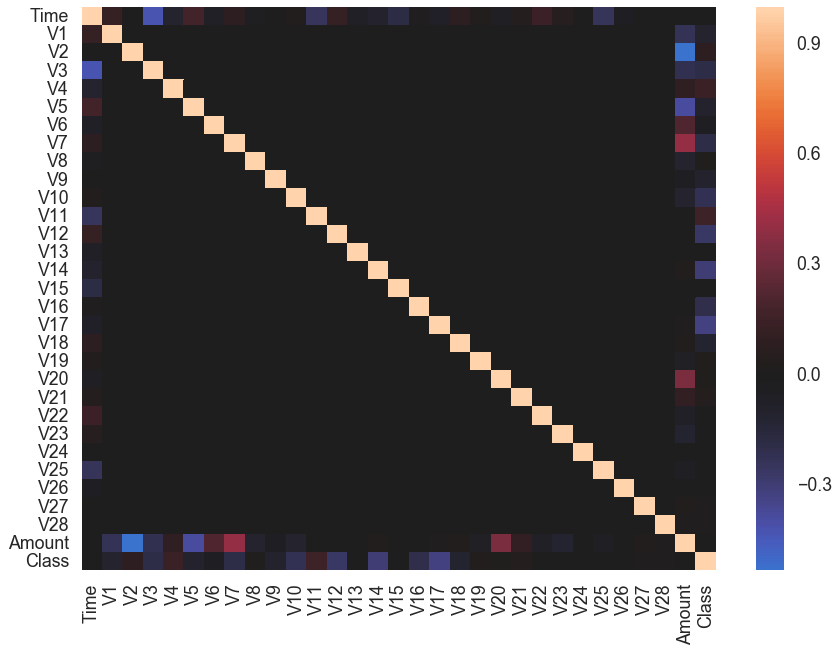

In [46]:
sns.heatmap(data.corr(), xticklabels=data.columns,yticklabels=data.columns,center=0)

Z mapy korelacji widać, że o znaczących liniowych zależnościach możemy mówić jedynie przy okazji czasu, kwot i klasy - przy czym zmienna czasowa póki co nie do końca ma sens(zajmiemy się nią niedługo), a mówienie o korelacji w przypadku kategorycznej zmiennej klasy jest kontrowersyjne. Brak najprostszych(liniowych) zależności pomiędzy zmiennymi może sugerować, że będziemy musieli budować bardziej złożony model lub też konstruować nowe zmienne, by wykorzystywać(być może istniejące) ukryte interakcje.

Jak już zostało wspomniane, zmienna czasowa w swojej obecnej postaci nie do końca ma sens. Dysponujemy informacjami o transakcjach z jedynie dwóch dni. Intuicja podpowiada, że zapewne dynamika badanego zjawiska nie zmieniła się z doby na dobę. Bardziej niż czas, który upłynął od początka napływu danych, interesuje nas raczej pora dnia, kkiedy transakcja została zawarta. Przerobimy więc tę zmienną, by dzień jako taki nie był w niej uwzględniony. W dodatku zamienimy sekundy na pełne godziny.

In [7]:
def sec_to_hours(seconds):
    hours = np.floor(seconds/3600)    #zamiana na pełne godziny
    hours = int(hours)    #przeróbka na typ int
    return hours%24       #dzielenie modulo, by znieść informację o dniu

In [8]:
data['Time'] = data['Time'].apply(sec_to_hours)    #działamy napisaną funkcją na nasze dane

In [44]:
X = data.drop('Class',axis=1)
y = data['Class']

Jedną z metod, by wyłuskać z danych nieliniowe zależności jest utworzenie tzw. polynomial features - zmiennych będących iloczynami oryginalnych kolumn podniesionych do potęg. Niestety, w naszym przypadku jest to problematyczne.

In [45]:
poly = PolynomialFeatures(degree=2,interaction_only=True)
X_poly = poly.fit_transform(X)

In [51]:
X_poly = pd.DataFrame(X_poly)
X_poly.describe()

,0,1,2,3,4,5,6,7,8,9,...,456,457,458,459,460,461,462,463,464,465
count,185124.0,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,...,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000,185124.000000
mean,1.0,14.040281,-0.002927,0.000832,0.001746,-0.003746,-0.000209,-0.000501,0.000192,-0.001361,...,-0.000077,-0.000472,-0.000291,-6.725458,0.000716,-0.000389,-0.676677,-0.002627,4.099803,0.459172
std,0.0,5.835693,1.967512,1.669363,1.514763,1.414687,1.391761,1.340648,1.255182,1.216856,...,0.290800,0.601105,0.622093,679.447582,0.351725,0.223676,315.858422,1.853081,1968.916253,1032.094059
min,1.0,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,...,-5.678289,-52.105235,-70.279137,-138102.517889,-8.270712,-52.703554,-49816.128192,-487.778869,-70812.245898,-396416.754431
25%,1.0,10.000000,-0.920424,-0.595819,-0.888159,-0.851680,-0.690318,-0.769846,-0.552346,-0.208154,...,-0.097084,-0.029102,-0.020198,-4.825380,-0.031302,-0.016378,-8.924521,-0.000463,-1.789728,-0.916071
50%,1.0,15.000000,0.013435,0.068600,0.179859,-0.022760,-0.055342,-0.273634,0.039859,0.022990,...,-0.009949,-0.001719,0.002044,0.040511,-0.003933,-0.000143,-0.237308,0.001426,0.001955,0.055268
75%,1.0,19.000000,1.314699,0.805852,1.029189,0.742206,0.610969,0.396147,0.571946,0.326724,...,0.069428,0.017898,0.014895,7.451666,0.012748,0.015027,2.718685,0.014734,1.417496,1.567437
max,1.0,23.000000,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,...,18.443670,143.983534,181.985953,117015.083440,107.975770,13.117665,87751.657233,42.270456,812154.039496,77625.150539


In [52]:
X_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185124 entries, 0 to 185123
Columns: 466 entries, 0 to 465
dtypes: float64(466)
memory usage: 658.2 MB


Rozmiar otrzymanej tabeli i pamięć przez nią zajmowana przekracza niestety nasze możliwości obliczeniowe. Będziemy musieli obejść się smakiem i poszukać innych metod.

Nasze dane są problematyczne pod jeszcze jednym względem - i jest to problem niebłahy. Pozytywna klasa stanowi tam ok. 0.172% całości. Oznacza to, że dane są skrajnie niezbalansowane i przez to problematyczne dla wielu klasycznych modeli. Są różne sposoby na poradzeni sobie z takim kłopotem. My skłonimy się oversamplingowi - syntetycznemu powieleniu mniejszościowych obserwacji(w losowy do pewnego stopnia sposób) tak, by doprowadzić do balansu.

In [10]:
sm = SMOTE(1)    #Synthetic Minority Over-sampling Technique. Jedynka oznacza, że docelowo chcemy mieć po  tyle samo obserwacji w klasach
X_balanced,y_balanced = sm.fit_resample(X,y)

Do stworzenia modelu posłużymy się biblioteką XGBoost. Jest to wszechstronne i bardzo efektywne narzędzie, które dobrze nada się do naszego zadania. 

Najwyższa pora, by poświęcić chwilę na omówienie kwestii oceny jakości naszego modelu. Najbardziej powszechną i natualną miarą przy zadaniach klasyfikacji jest "accuracy" - stosunek obserwacji dobrze zaklysyfikowancy do wszystkich klasyfikowanych. W naszym przypadku nie zda to egzaminu, Gdybyśmy przy naszym przypadku ponad 99% "negatywnych" rekordów przyjęli taką miarę, znakomitym modelem byłby człowiek uznający każdą transakcję za uczciwą. Potrzebujemy czegoś celniejszego. Tak naprawdę idealnie byłoby skonstruować nieco "spersonalizowaną" miarę w porozumieniu z ekspertami, tj. ludźmi, dla których interesujące nas dane i zbudowany przez nas model byłyby chlebem powszednim. Wtedy moglibyśmy ustalić, jak bardzo chcemy wychwytywać możliiwie duży odsetek fraudów i jak bardzo godzimy się na niesłuszne oskarżanie uczciwych transakcji. Interesować będą nas zapewne miary "presicion" i "recall". Sensownym pomysłem mogłoby być użycie miary F1, tj. średniej harmoniznej tych dwóch wartości. Ta miara zakłada jednak niejako "uczciwy udział" w wyniku tych dwóch podstawowych miar. Użycie krzywej ROC i jej pochodnej - pola pod nią - daje chyba większą elastyczność w ocenie modelu dla ewentualnych różnych wag presicion i recall w realnych zastosowaniach. Użyjemy więc miary AUC(AUROC).

Poświęcmy jeszcze chwilę parametrowi modelu decydującemu o tym, jak głęboko mogą budować się drzewa składające się na kolejne iteracje boostingu. Ogólnie przyjętą praktyką jest używanie płytkih drzew(nawet "pni"  - drzew z jednym podziałem). Z drugiej jednak strony - takie drzewa mają małe szanse na wychwycenie głębokich zależnośc i interakcji. W odniesieniu do uwag przy maoie korelacji, dajmy szansę głębszym drzewom i przetestujmy nieco większe warości parametru "max_depth".

In [36]:
param = {'xgb_model__max_depth': [1,3,7], 'xgb_model__eta': [0.1,0.5], 'xgb_model__objective': ['binary:logistic']} #parametry do przetestowania

In [37]:
xgb_model = xgb.XGBClassifier()

In [39]:
clf = GridSearchCV(xgb_model,param,scoring='roc_auc')    #inicjalizacjia obiektu GridSearch
clf.fit(X_balanced,y_balanced)     #poszukiwanie optymalnych parametrów modelu

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='warn', n_jobs=None,
             param_grid={'xgb_model__eta': [0.1, 0.5],
                         'xgb_model__max_depth': [1, 3, 7],
                         'xgb_model__objective': ['binary:logistic']},
         

In [40]:
model = clf.best_estimator_

In [41]:
clf.best_params_

{'xgb_model__eta': 0.1,
 'xgb_model__max_depth': 1,
 'xgb_model__objective': 'binary:logistic'}

In [53]:
clf.best_score_

0.9994826552661003

Cóż - nasze hipotezy zdają się zawodzić! Najlepszy wynik dają bardzo standardowe wartości tempa uczenia na poziomie 0.1 i używanie pni jako boostingowych estymatorów. Otrzymaliśmy jednak nadzwyczaj optymistyczny wynik. Nadszedł czas na walidację modelu

In [57]:
hold_out.Time = hold_out.Time.apply(sec_to_hours)    #modyfikacja zmiennej - jak wcześniej

In [59]:
X_test = hold_out.drop('Class',axis=1)

In [66]:
x = np.array(X_test)

In [74]:
y_pred = model.predict(x)

In [75]:
roc_auc_score(hold_out['Class'],y_pred)

0.9522551030352376

Wynik nieco spadł w porównaniu do walidacji krzyżowej na zbiorze treningowym, nadal jednak jest wysoki. Kolejne kroki, wiodące być może do jeszcze lepszego wyniku, wymagałyby większego nakładu pracy procesora - stworzenei polynomial features, porządniejsze przeszukanie przestrzeni parametrów czy użycie innego algorytmu - np. SVMów. Szczególnie sensownie brzmi połączenie dwóch ostatnich kroków - polynomial features tworzą wiele nowych zmiennych, a algorytmy oparte o SVM dobrze sprawdzają się przy wysokich stosunkach kolumn do rekordów(nawet powyżej jedynki). Z większą wiedzą o danych pożądane byłoby też wyjaśnienie modelu(w oparciu choćby o metody shapleyowskie). Tymczasem jednak i tak  zdaje się, że uzyskaliśmy dobry sposób na wykrywania fraudw wśród transakcji.